CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Check for MPS (Metal Performance Shaders) availability on Apple Silicon
mps_available = torch.backends.mps.is_available()
print(f"MPS Available: {mps_available}")

# Check if MPS is built (compiled with MPS support)
mps_built = torch.backends.mps.is_built()
print(f"MPS Built: {mps_built}")

# Set device based on availability
if mps_available and mps_built:
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Selected device: {device}")

# Test MPS with a simple tensor operation
if device.type == "mps":
    try:
        # Create a simple tensor on MPS
        test_tensor = torch.randn(3, 3, device=device)
        result = test_tensor @ test_tensor.T
        print("✅ MPS test successful!")
        print(f"Test tensor shape: {test_tensor.shape}")
        print(f"Result tensor shape: {result.shape}")
    except Exception as e:
        print(f"❌ MPS test failed: {e}")
        print("Falling back to CPU")
        device = torch.device("cpu")


MPS Available: True
MPS Built: True
Using MPS (Apple Silicon GPU)
Selected device: mps
✅ MPS test successful!
Test tensor shape: torch.Size([3, 3])
Result tensor shape: torch.Size([3, 3])


CODE BLOCK: 2

In [3]:
# CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)

CODE BLOCK: 3

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

CODE BLOCK: 5

In [ ]:
print(f"Train Data shape: {train_data.targets.shape}, Test Data shape:  {test_data.targets.shape}")

Train Data shape: torch.Size([60000]), Test Data shape:  torch.Size([10000])


In [13]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [15]:
print(f"Train Loader Data Shape: {train_loader.dataset.targets.shape}, Test Loader Data Shape:  {test_loader.dataset.targets.shape}")

Train Loader Data Shape: torch.Size([60000]), Test Loader Data Shape:  torch.Size([10000])


CODE BLOCK: 6

/Users/pankajkumar/Documents/git/TSAI/ERA4/S4/mnist-training-epo1/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


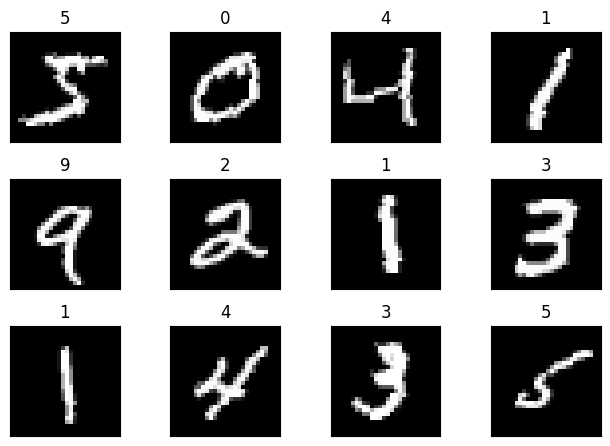

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(256*4*4, 50) # 16000
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        print(x.shape, x.numel())
        x = F.relu(self.conv1(x), 2)
        print(x.shape, x.numel())
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        print(x.shape, x.numel())
        x = F.relu(self.conv3(x), 2)
        print(x.shape, x.numel())
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        print(x.shape, x.numel())
        x = x.view(-1, 256*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


CODE BLOCK: 8

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [47]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [48]:
from tabnanny import verbose


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# New Line
criterion = nn.CrossEntropyLoss(reduction='sum')
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Epoch 1


  0%|          | 0/118 [00:00<?, ?it/s]/Users/pankajkumar/Documents/git/TSAI/ERA4/S4/mnist-training-epo1/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train: Loss=nan Batch_id=3 Accuracy=9.52:   1%|          | 1/118 [00:01<01:58,  1.01s/it]                   

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=15 Accuracy=10.05:  11%|█         | 13/118 [00:01<00:06, 15.86it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=27 Accuracy=10.07:  21%|██        | 25/118 [00:01<00:03, 30.37it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=39 Accuracy=9.95:  31%|███▏      | 37/118 [00:01<00:01, 41.57it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=51 Accuracy=9.85:  42%|████▏     | 49/118 [00:01<00:01, 48.71it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=63 Accuracy=9.81:  52%|█████▏    | 61/118 [00:02<00:01, 52.46it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=75 Accuracy=9.80:  62%|██████▏   | 73/118 [00:02<00:00, 54.73it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=87 Accuracy=9.84:  72%|███████▏  | 85/118 [00:02<00:00, 55.81it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=99 Accuracy=9.88:  82%|████████▏ | 97/118 [00:02<00:00, 56.54it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=111 Accuracy=9.88:  92%|█████████▏| 109/118 [00:02<00:00, 56.98it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.88:  97%|█████████▋| 115/118 [00:03<00:00, 57.20it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([96, 1, 28, 28]) 96 75264
torch.Size([96, 32, 26, 26]) 96 2076672
torch.Size([96, 64, 12, 12]) 96 884736
torch.Size([96, 128, 10, 10]) 96 1228800
torch.S

Train: Loss=nan Batch_id=117 Accuracy=9.88: 100%|██████████| 118/118 [00:03<00:00, 36.20it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  9.05it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:03, 24.83it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.57it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=40 Accuracy=9.96:  31%|███▏      | 37/118 [00:01<00:02, 35.60it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=52 Accuracy=9.82:  42%|████▏     | 49/118 [00:01<00:01, 44.66it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=64 Accuracy=9.82:  52%|█████▏    | 61/118 [00:02<00:01, 49.87it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=76 Accuracy=9.79:  62%|██████▏   | 73/118 [00:02<00:00, 53.20it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=88 Accuracy=9.85:  72%|███████▏  | 85/118 [00:02<00:00, 55.29it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=100 Accuracy=9.87:  82%|████████▏ | 97/118 [00:02<00:00, 56.89it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=112 Accuracy=9.88:  92%|█████████▏| 109/118 [00:02<00:00, 57.75it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:03<00:00, 58.09it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([96, 1, 28, 28]) 96 75264
torch.Size([96, 32, 26, 26]) 96 2076672
torch.Size([96, 64, 12, 12]) 96 884736
torch.Size([96, 128, 10, 10]) 96 1228800
torch.Size([96, 256, 4, 4]) 96 393216


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.74it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=8 Accuracy=9.55:   6%|▌         | 7/118 [00:01<00:13,  8.32it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=20 Accuracy=10.02:  16%|█▌        | 19/118 [00:01<00:04, 23.23it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=31 Accuracy=10.00:  26%|██▋       | 31/118 [00:01<00:02, 35.99it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=43 Accuracy=9.95:  36%|███▋      | 43/118 [00:01<00:01, 44.64it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=55 Accuracy=9.84:  47%|████▋     | 55/118 [00:01<00:01, 49.91it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=67 Accuracy=9.83:  57%|█████▋    | 67/118 [00:02<00:00, 53.52it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=79 Accuracy=9.84:  67%|██████▋   | 79/118 [00:02<00:00, 55.82it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=91 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.24it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=103 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 56.56it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=115 Accuracy=9.88:  97%|█████████▋| 115/118 [00:03<00:00, 56.72it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:03<00:00, 56.72it/s]

torch.Size([96, 1, 28, 28]) 96 75264
torch.Size([96, 32, 26, 26]) 96 2076672
torch.Size([96, 64, 12, 12]) 96 884736
torch.Size([96, 128, 10, 10]) 96 1228800
torch.Size([96, 256, 4, 4]) 96 393216


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.15it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  8.81it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:04, 24.48it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.49it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=45 Accuracy=9.93:  36%|███▋      | 43/118 [00:01<00:01, 46.34it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=57 Accuracy=9.88:  47%|████▋     | 55/118 [00:01<00:01, 51.29it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=69 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 54.41it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=81 Accuracy=9.86:  67%|██████▋   | 79/118 [00:02<00:00, 55.97it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=93 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.82it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=105 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 57.14it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:02<00:00, 57.30it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 37.33it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  8.81it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:04, 24.54it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.72it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=45 Accuracy=9.93:  36%|███▋      | 43/118 [00:01<00:01, 46.58it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=57 Accuracy=9.88:  47%|████▋     | 55/118 [00:01<00:01, 52.01it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=69 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 54.69it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=81 Accuracy=9.86:  67%|██████▋   | 79/118 [00:02<00:00, 56.23it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=93 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.38it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=105 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 56.89it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:02<00:00, 57.29it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 37.40it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  8.73it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:04, 24.40it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.51it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=45 Accuracy=9.93:  36%|███▋      | 43/118 [00:01<00:01, 46.47it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=57 Accuracy=9.88:  47%|████▋     | 55/118 [00:01<00:01, 51.78it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=69 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 54.78it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=81 Accuracy=9.86:  67%|██████▋   | 79/118 [00:02<00:00, 56.15it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=93 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.80it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=105 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 56.95it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:02<00:00, 57.29it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 37.03it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=8 Accuracy=9.55:   5%|▌         | 6/118 [00:01<00:15,  7.34it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=19 Accuracy=10.03:  15%|█▌        | 18/118 [00:01<00:04, 23.13it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=31 Accuracy=10.00:  25%|██▌       | 30/118 [00:01<00:02, 36.55it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=43 Accuracy=9.95:  36%|███▌      | 42/118 [00:01<00:01, 45.81it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=55 Accuracy=9.84:  46%|████▌     | 54/118 [00:01<00:01, 51.22it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=67 Accuracy=9.83:  56%|█████▌    | 66/118 [00:02<00:00, 54.34it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=79 Accuracy=9.84:  66%|██████▌   | 78/118 [00:02<00:00, 55.97it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=91 Accuracy=9.84:  76%|███████▋  | 90/118 [00:02<00:00, 56.65it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=103 Accuracy=9.87:  86%|████████▋ | 102/118 [00:02<00:00, 57.11it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=115 Accuracy=9.88:  97%|█████████▋| 114/118 [00:02<00:00, 56.98it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.86it/s]

torch.Size([96, 1, 28, 28]) 96 75264
torch.Size([96, 32, 26, 26]) 96 2076672
torch.Size([96, 64, 12, 12]) 96 884736
torch.Size([96, 128, 10, 10]) 96 1228800
torch.Size([96, 256, 4, 4]) 96 393216


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:13,  8.42it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=19 Accuracy=10.03:  16%|█▌        | 19/118 [00:01<00:04, 23.36it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=30 Accuracy=10.02:  26%|██▋       | 31/118 [00:01<00:02, 35.64it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=42 Accuracy=9.96:  36%|███▋      | 43/118 [00:01<00:01, 44.96it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=54 Accuracy=9.83:  47%|████▋     | 55/118 [00:01<00:01, 50.60it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=66 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 53.68it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=78 Accuracy=9.85:  67%|██████▋   | 79/118 [00:02<00:00, 55.34it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=90 Accuracy=9.82:  77%|███████▋  | 91/118 [00:02<00:00, 56.10it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=102 Accuracy=9.88:  87%|████████▋ | 103/118 [00:02<00:00, 56.18it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=114 Accuracy=9.88:  97%|█████████▋| 115/118 [00:03<00:00, 56.71it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:03<00:00, 56.71it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([96, 1, 28, 28]) 96 75264
torch.Size([96, 32, 26, 26]) 96 2076672
torch.Size([96, 64, 12, 12]) 96 884736
torch.Size([96, 128, 10, 10]) 96 1228800
torch.Size([96, 256, 4, 4]) 96 393216


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.14it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=8 Accuracy=9.55:   6%|▌         | 7/118 [00:01<00:13,  8.52it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=20 Accuracy=10.02:  16%|█▌        | 19/118 [00:01<00:04, 23.89it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=32 Accuracy=9.96:  26%|██▋       | 31/118 [00:01<00:02, 37.00it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=44 Accuracy=9.96:  36%|███▋      | 43/118 [00:01<00:01, 45.78it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=56 Accuracy=9.83:  47%|████▋     | 55/118 [00:01<00:01, 51.05it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=68 Accuracy=9.80:  57%|█████▋    | 67/118 [00:02<00:00, 54.07it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=80 Accuracy=9.87:  67%|██████▋   | 79/118 [00:02<00:00, 55.77it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=92 Accuracy=9.85:  77%|███████▋  | 91/118 [00:02<00:00, 56.18it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=104 Accuracy=9.88:  87%|████████▋ | 103/118 [00:02<00:00, 56.73it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:03<00:00, 57.03it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.74it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  8.77it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:04, 24.40it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.40it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=45 Accuracy=9.93:  36%|███▋      | 43/118 [00:01<00:01, 46.17it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=57 Accuracy=9.88:  47%|████▋     | 55/118 [00:01<00:01, 51.19it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=69 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 54.16it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=81 Accuracy=9.86:  67%|██████▋   | 79/118 [00:02<00:00, 55.59it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=93 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.46it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=105 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 56.55it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:02<00:00, 56.89it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 37.08it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  8.77it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:04, 24.45it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.52it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=45 Accuracy=9.93:  36%|███▋      | 43/118 [00:01<00:01, 46.25it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=57 Accuracy=9.88:  47%|████▋     | 55/118 [00:01<00:01, 51.46it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=69 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 54.02it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=81 Accuracy=9.86:  67%|██████▋   | 79/118 [00:02<00:00, 55.59it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=93 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.45it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=105 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 56.81it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:02<00:00, 57.02it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 37.14it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=8 Accuracy=9.55:   6%|▌         | 7/118 [00:01<00:13,  8.46it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=20 Accuracy=10.02:  16%|█▌        | 19/118 [00:01<00:04, 23.84it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=32 Accuracy=9.96:  26%|██▋       | 31/118 [00:01<00:02, 36.97it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=44 Accuracy=9.96:  36%|███▋      | 43/118 [00:01<00:01, 46.06it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=56 Accuracy=9.83:  47%|████▋     | 55/118 [00:01<00:01, 51.39it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=68 Accuracy=9.80:  57%|█████▋    | 67/118 [00:02<00:00, 54.33it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=80 Accuracy=9.87:  67%|██████▋   | 79/118 [00:02<00:00, 55.46it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=92 Accuracy=9.85:  77%|███████▋  | 91/118 [00:02<00:00, 56.80it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=104 Accuracy=9.88:  87%|████████▋ | 103/118 [00:02<00:00, 57.19it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:03<00:00, 57.63it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.70it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=8 Accuracy=9.55:   6%|▌         | 7/118 [00:01<00:13,  8.45it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=19 Accuracy=10.03:  16%|█▌        | 19/118 [00:01<00:04, 23.82it/s]

torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 110755

Train: Loss=nan Batch_id=31 Accuracy=10.00:  26%|██▋       | 31/118 [00:01<00:02, 36.95it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=43 Accuracy=9.95:  36%|███▋      | 43/118 [00:01<00:01, 46.00it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=55 Accuracy=9.84:  47%|████▋     | 55/118 [00:01<00:01, 51.25it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=67 Accuracy=9.83:  57%|█████▋    | 67/118 [00:02<00:00, 54.16it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=78 Accuracy=9.85:  67%|██████▋   | 79/118 [00:02<00:00, 54.29it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=90 Accuracy=9.82:  77%|███████▋  | 91/118 [00:02<00:00, 54.82it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=101 Accuracy=9.88:  82%|████████▏ | 97/118 [00:02<00:00, 55.38it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=113 Accuracy=9.88:  92%|█████████▏| 109/118 [00:02<00:00, 56.21it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:03<00:00, 56.43it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([96, 1, 28, 28]) 96 75264
torch.Size([96, 32, 26, 26]) 96 2076672
torch.Size([96, 64, 12, 12]) 96 884736
torch.Size([96, 128, 10, 10]) 96 1228800
torch.Size([96, 256, 4, 4]) 96 393216


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.18it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=8 Accuracy=9.55:   6%|▌         | 7/118 [00:01<00:13,  8.50it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=20 Accuracy=10.02:  16%|█▌        | 19/118 [00:01<00:04, 23.84it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=32 Accuracy=9.96:  26%|██▋       | 31/118 [00:01<00:02, 36.95it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=44 Accuracy=9.96:  36%|███▋      | 43/118 [00:01<00:01, 45.96it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=56 Accuracy=9.83:  47%|████▋     | 55/118 [00:01<00:01, 51.48it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=68 Accuracy=9.80:  57%|█████▋    | 67/118 [00:02<00:00, 54.23it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=80 Accuracy=9.87:  67%|██████▋   | 79/118 [00:02<00:00, 55.07it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=92 Accuracy=9.85:  77%|███████▋  | 91/118 [00:02<00:00, 56.12it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=104 Accuracy=9.88:  87%|████████▋ | 103/118 [00:02<00:00, 56.58it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:03<00:00, 56.92it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.72it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=8 Accuracy=9.55:   5%|▌         | 6/118 [00:01<00:15,  7.33it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=20 Accuracy=10.02:  15%|█▌        | 18/118 [00:01<00:04, 23.22it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=32 Accuracy=9.96:  25%|██▌       | 30/118 [00:01<00:02, 36.59it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=44 Accuracy=9.96:  36%|███▌      | 42/118 [00:01<00:01, 45.57it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=56 Accuracy=9.83:  46%|████▌     | 54/118 [00:01<00:01, 51.13it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=68 Accuracy=9.80:  56%|█████▌    | 66/118 [00:02<00:00, 54.17it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=80 Accuracy=9.87:  66%|██████▌   | 78/118 [00:02<00:00, 55.25it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=92 Accuracy=9.85:  76%|███████▋  | 90/118 [00:02<00:00, 56.11it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=104 Accuracy=9.88:  86%|████████▋ | 102/118 [00:02<00:00, 56.72it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 114/118 [00:03<00:00, 56.91it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.60it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  8.67it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:04, 24.17it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.14it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=45 Accuracy=9.93:  36%|███▋      | 43/118 [00:01<00:01, 46.11it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=57 Accuracy=9.88:  47%|████▋     | 55/118 [00:01<00:01, 51.48it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=69 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 54.57it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=81 Accuracy=9.86:  67%|██████▋   | 79/118 [00:02<00:00, 55.94it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=93 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.16it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=105 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 56.47it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:02<00:00, 56.80it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.88it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  8.70it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:04, 24.25it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.09it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=45 Accuracy=9.93:  36%|███▋      | 43/118 [00:01<00:01, 46.07it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=57 Accuracy=9.88:  47%|████▋     | 55/118 [00:01<00:01, 51.31it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=69 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 54.33it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=81 Accuracy=9.86:  67%|██████▋   | 79/118 [00:02<00:00, 55.31it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=93 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.42it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=105 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 56.73it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:02<00:00, 56.89it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 37.01it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=8 Accuracy=9.55:   5%|▌         | 6/118 [00:01<00:15,  7.31it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=19 Accuracy=10.03:  15%|█▌        | 18/118 [00:01<00:04, 23.12it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=31 Accuracy=10.00:  25%|██▌       | 30/118 [00:01<00:02, 36.48it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=43 Accuracy=9.95:  36%|███▌      | 42/118 [00:01<00:01, 45.72it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=55 Accuracy=9.84:  46%|████▌     | 54/118 [00:01<00:01, 51.16it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=67 Accuracy=9.83:  56%|█████▌    | 66/118 [00:02<00:00, 54.21it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=79 Accuracy=9.84:  66%|██████▌   | 78/118 [00:02<00:00, 55.64it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=91 Accuracy=9.84:  76%|███████▋  | 90/118 [00:02<00:00, 55.99it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=103 Accuracy=9.87:  86%|████████▋ | 102/118 [00:02<00:00, 56.21it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=115 Accuracy=9.88:  97%|█████████▋| 114/118 [00:03<00:00, 56.69it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 114/118 [00:03<00:00, 56.69it/s]

torch.Size([96, 1, 28, 28]) 96 75264
torch.Size([96, 32, 26, 26]) 96 2076672
torch.Size([96, 64, 12, 12]) 96 884736
torch.Size([96, 128, 10, 10]) 96 1228800
torch.Size([96, 256, 4, 4]) 96 393216


Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.55it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  8.70it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:04, 24.25it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.29it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=45 Accuracy=9.93:  36%|███▋      | 43/118 [00:01<00:01, 46.02it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=57 Accuracy=9.88:  47%|████▋     | 55/118 [00:01<00:01, 50.98it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=69 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 53.92it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=81 Accuracy=9.86:  67%|██████▋   | 79/118 [00:02<00:00, 55.50it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=93 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.33it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=105 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 56.58it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:02<00:00, 56.79it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.95it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=9 Accuracy=9.63:   6%|▌         | 7/118 [00:01<00:12,  8.71it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=21 Accuracy=9.99:  16%|█▌        | 19/118 [00:01<00:04, 24.24it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=33 Accuracy=9.94:  26%|██▋       | 31/118 [00:01<00:02, 37.25it/s] 

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=45 Accuracy=9.93:  36%|███▋      | 43/118 [00:01<00:01, 45.86it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=57 Accuracy=9.88:  47%|████▋     | 55/118 [00:01<00:01, 51.25it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=69 Accuracy=9.82:  57%|█████▋    | 67/118 [00:02<00:00, 54.11it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=81 Accuracy=9.86:  67%|██████▋   | 79/118 [00:02<00:00, 55.33it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=93 Accuracy=9.84:  77%|███████▋  | 91/118 [00:02<00:00, 56.19it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=105 Accuracy=9.87:  87%|████████▋ | 103/118 [00:02<00:00, 56.87it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87:  97%|█████████▋| 115/118 [00:02<00:00, 56.82it/s]

torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

Train: Loss=nan Batch_id=117 Accuracy=9.87: 100%|██████████| 118/118 [00:03<00:00, 36.92it/s]


torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553600
torch.Size([512, 256, 4, 4]) 512 2097152
torch.Size([512, 1, 28, 28]) 512 401408
torch.Size([512, 32, 26, 26]) 512 11075584
torch.Size([512, 64, 12, 12]) 512 4718592
torch.Size([512, 128, 10, 10]) 512 6553

CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

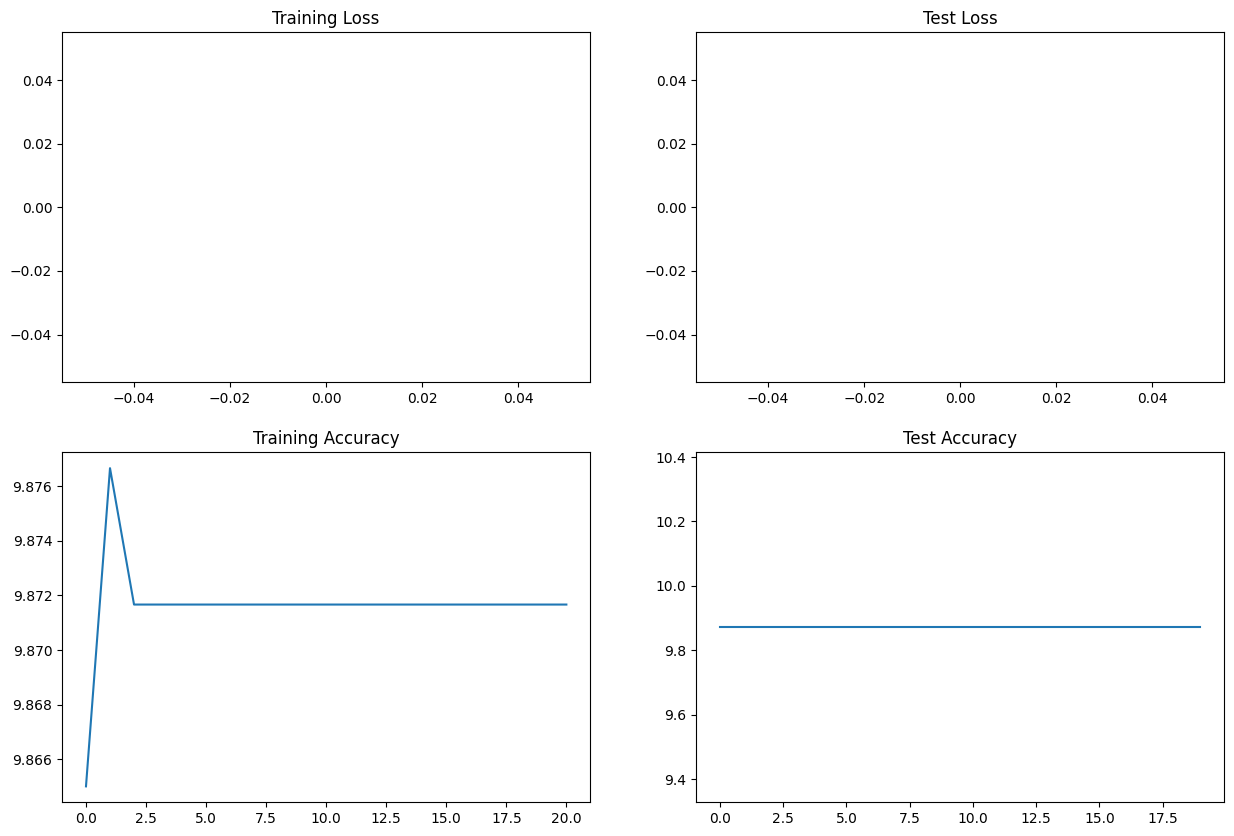

In [49]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
# # !pip install torchsummary
# from torchsummary import summary
# # use_cuda = torch.cuda.is_available()
# use_mps = torch.backends.mps.is_available()
# # device = torch.device("cuda" if use_cuda else "cpu")
# device = torch.device("mps" if use_mps else "cpu")

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            295,168
├─Linear: 1-5                            204,850
├─Linear: 1-6                            510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            295,168
├─Linear: 1-5                            204,850
├─Linear: 1-6                            510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0

In [ ]:
from torchsummary import summary
model = Net().to(device)
summary(model, input_size=(1, 28, 28))